In [20]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.classifyingEdges.classifyingEdges import *
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

In [21]:
# Load model
model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
# url = "C:\\Users\\micha\\Documents\\Imperial Courses\\Thesis\\IAEA-thesis\\data\\swde\\sourceCode\\sourceCode\\movie\\movie\\movie-allmovie(2000)\\0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
url = "https://westinghousenuclear.com/"
# url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
# url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
# url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
downloadHTML(url,1,htmlFile)

Saved https://westinghousenuclear.com/ → /vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html
Page limit hit


In [22]:
# Get label edges from text nodes in the website
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, remove_dupes=REMOVE_DUPES)

In [23]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, "'\\s"), normalise_text(b, "'\\s")])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)

In [24]:
# Remove all html instructional labels
txtsShortened = [[a.split(".")[0], b.split(".")[0]] for a, b in txts]
isInstruction, instructionalTxt = clean_instructional_text(txtsShortened, batch_size=64)
opmask = np.array(isInstruction, dtype=bool)
mask = np.logical_not(opmask)

for key, value in instructionalTxt.items():
    if value == 1:
        print(key)

learn more about why databricks selected westinghouse ai for its 2025 data intelligence in energy utility award
read more
enhance your training staffing and outsourcing needs with our training and resource solutions
explore careers
take a look
access our custom technology library designed for nuclear engineering students and professionals
x click on the background to close the video
learn more watch video
explore our interactive 3d visualization tool for innovative answers to operating plant challenges
learn more
blog
join our team
explore
explore now
learn more about how westinghouse enhances training staffing and outsourcing with options that benefit your plants bottom line
westinghouse partnered with the richland county ems to host a series of training videos at their facility the training videos filmed onsite at westinghouse in hopkins signals a collaboration that focuses on producing highquality instructional content aimed at improving skills and knowledge among emergency medical 

In [25]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

In [26]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.15, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = mask 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

2162  ->  181


['balancing wind solar and nuclear power will help achieve a carbonfree future and positively impact our changing climate over the past 50 years globally nuclear power has avoided nearly two years of the worlds energyrelated co2 emissions imagine how much more carbon pollution we can prevent'
 'nuclear energyprovides 55 of the uss and 14 of the worlds carbonfree energy']
['nuclear energyprovides 55 of the uss and 14 of the worlds carbonfree energy'
 'balancing wind solar and nuclear power will help achieve a carbonfree future and positively impact our changing climate over the past 50 years globally nuclear power has avoided nearly two years of the worlds energyrelated co2 emissions imagine how much more carbon pollution we can prevent']
['carbonfree energy'
 'nuclear energyprovides 55 of the uss and 14 of the worlds carbonfree energy']


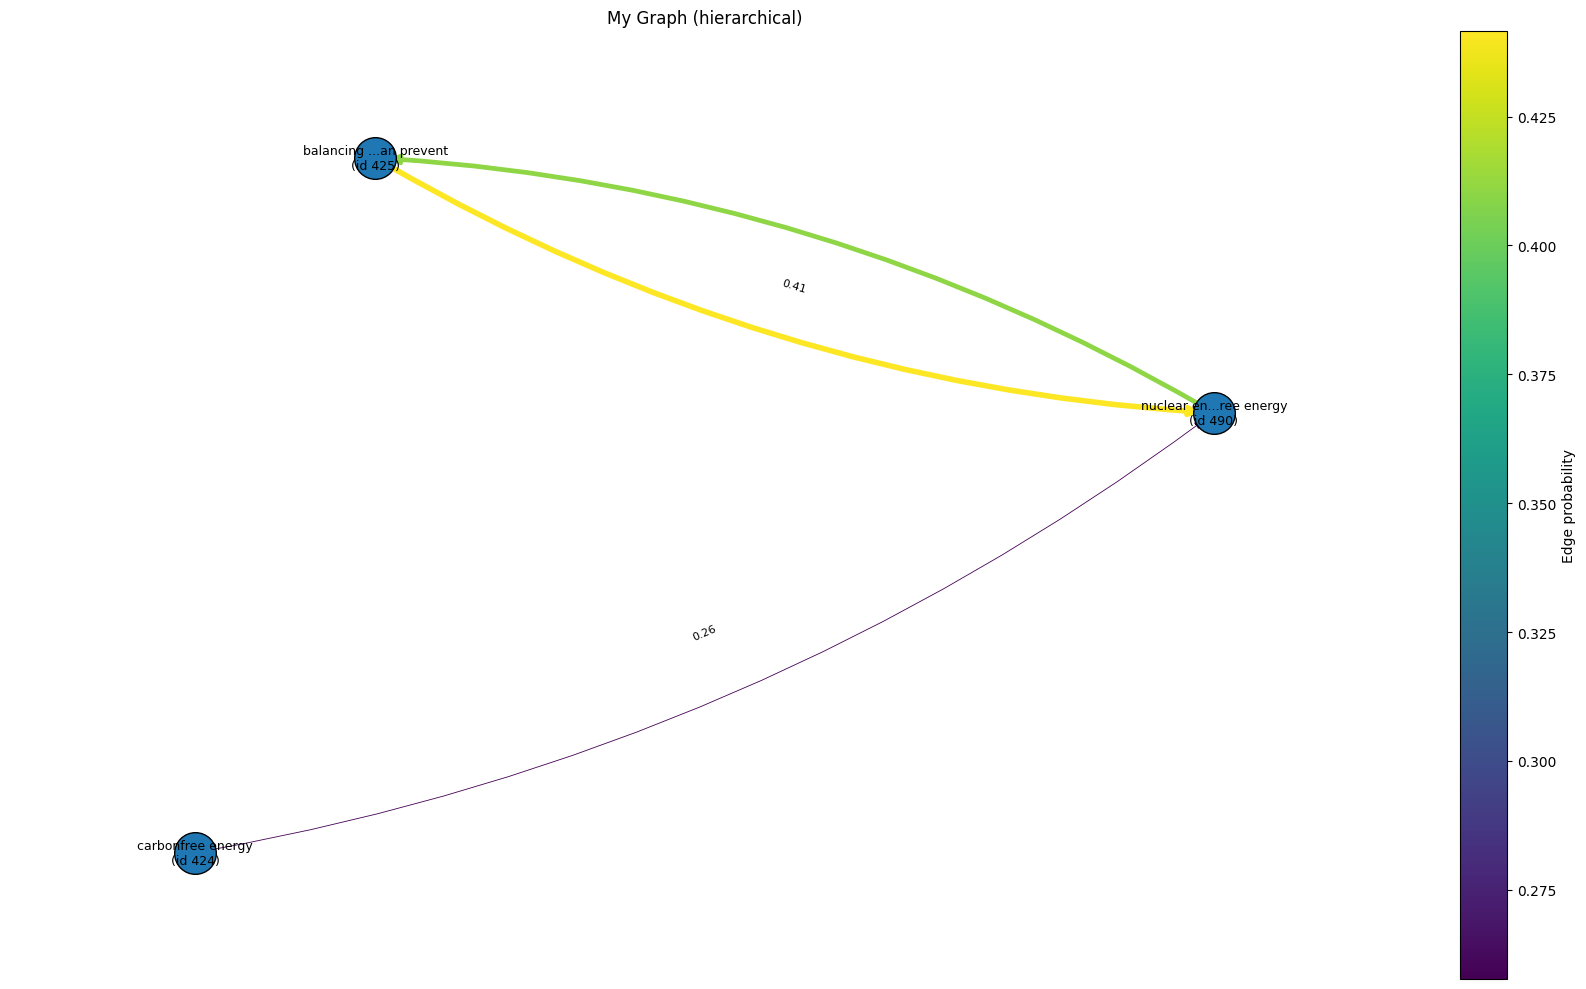

{'G': <networkx.classes.digraph.DiGraph at 0x7e809a271bb0>,
 'pos': {425: array([-0.21827276,  0.83713974]),
  490: array([0.61509842, 0.16286026]),
  424: array([-0.39682566, -1.        ])},
 'fig': <Figure size 1600x1000 with 2 Axes>,
 'ax': <Axes: title={'center': 'My Graph (hierarchical)'}>}

In [27]:
# Display the graph
#textmask = np.array([True]*len(txts))
textmask = filterTextMask(txts, "provides", False) #& mask = keepTopKMask(txts, 1)

numToShow=-1
for row in zip(sorted_label_index[textmask][:numToShow], xpaths[textmask][:numToShow], txts[textmask][:numToShow], probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=txts[textmask][:numToShow],
    id_edge_pairs=sorted_label_index[textmask][:numToShow],
    xpath_edge_pairs=xpaths[textmask][:numToShow],
    probs=probs[textmask][:numToShow],
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=5.0,    # spread layers further
    node_spacing=2.5,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)